In [85]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import csv
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
url = 'https://coinmarketcap.com/historical/20251005/'
response = requests.get(url)
html_content = response.text
response

<Response [200]>

In [47]:
scraper = BeautifulSoup(html_content, 'html.parser')

In [48]:
table = scraper.find_all('table')[2]
rows = table.find_all('tr')
headers = [header.text.strip() for header in table.find_all('th')]
for i in range(1, min(len(rows), 21)):
    row = rows[i]
    cells = [cell.text.strip() for cell in row.find_all('td')]
    if cells:
        data = dict(zip(headers, cells))
        print(data)

{'Rank': '1', 'Name': 'BTCBitcoin', 'Symbol': 'BTC', 'Market Cap': '$2,461,401,577,407.10', 'Price': '$123,513.47', 'Circulating Supply': '19,928,203 BTC', 'volume (24h)': '$73,689,317,763.05', '% 1h': '0.20%', '% 24h': '0.89%', '% 7d': '10.16%', '': ''}
{'Rank': '2', 'Name': 'ETHEthereum', 'Symbol': 'ETH', 'Market Cap': '$545,026,231,211.62', 'Price': '$4,515.42', 'Circulating Supply': '120,703,251 ETH *', 'volume (24h)': '$44,880,806,324.30', '% 1h': '0.03%', '% 24h': '0.58%', '% 7d': '9.03%', '': ''}
{'Rank': '3', 'Name': 'XRPXRP', 'Symbol': 'XRP', 'Market Cap': '$177,857,347,529.48', 'Price': '$2.9706', 'Circulating Supply': '59,871,700,035 XRP *', 'volume (24h)': '$5,535,126,764.47', '% 1h': '0.08%', '% 24h': '0.04%', '% 7d': '3.63%', '': ''}
{'Rank': '4', 'Name': 'USDTTether USDt', 'Symbol': 'USDT', 'Market Cap': '$177,065,729,228.93', 'Price': '$1.0002', 'Circulating Supply': '177,030,700,466 USDT *', 'volume (24h)': '$158,608,091,664.97', '% 1h': '0.00%', '% 24h': '-0.01%', '% 

In [49]:
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    table = scraper.find_all('table')[2]
    rows = table.find_all('tr')
    headers = [header.text.strip() for header in table.find_all('th')]
    for i in range(1, min(len(rows), 21)):
        row = rows[i]
        cells = [cell.text.strip() for cell in row.find_all('td')]
        if cells:
            writer.writerow(cells)

In [50]:
df = pd.read_csv('output.csv')

In [51]:
df.head(5)

,Rank,Name,Symbol,Market Cap,Price,Circulating Supply,volume (24h),% 1h,% 24h,% 7d,Unnamed: 10
0,1,BTCBitcoin,BTC,"$2,461,401,577,407.10","$123,513.47","19,928,203 BTC","$73,689,317,763.05",0.20%,0.89%,10.16%,NaN
1,2,ETHEthereum,ETH,"$545,026,231,211.62","$4,515.42","120,703,251 ETH *","$44,880,806,324.30",0.03%,0.58%,9.03%,NaN
2,3,XRPXRP,XRP,"$177,857,347,529.48",$2.9706,"59,871,700,035 XRP *","$5,535,126,764.47",0.08%,0.04%,3.63%,NaN
3,4,USDTTether USDt,USDT,"$177,065,729,228.93",$1.0002,"177,030,700,466 USDT *","$158,608,091,664.97",0.00%,-0.01%,-0.02%,NaN
4,5,BNBBNB,BNB,"$162,223,663,310.34","$1,165.53","139,184,751 BNB *","$3,611,451,465.11",0.34%,1.30%,17.34%,NaN


In [52]:
df.drop(['Unnamed: 10'], axis=1, inplace=True)
df = df.drop(['Rank'], axis=1)
df.head(5)

,Name,Symbol,Market Cap,Price,Circulating Supply,volume (24h),% 1h,% 24h,% 7d
0,BTCBitcoin,BTC,"$2,461,401,577,407.10","$123,513.47","19,928,203 BTC","$73,689,317,763.05",0.20%,0.89%,10.16%
1,ETHEthereum,ETH,"$545,026,231,211.62","$4,515.42","120,703,251 ETH *","$44,880,806,324.30",0.03%,0.58%,9.03%
2,XRPXRP,XRP,"$177,857,347,529.48",$2.9706,"59,871,700,035 XRP *","$5,535,126,764.47",0.08%,0.04%,3.63%
3,USDTTether USDt,USDT,"$177,065,729,228.93",$1.0002,"177,030,700,466 USDT *","$158,608,091,664.97",0.00%,-0.01%,-0.02%
4,BNBBNB,BNB,"$162,223,663,310.34","$1,165.53","139,184,751 BNB *","$3,611,451,465.11",0.34%,1.30%,17.34%


In [74]:
df_pca = df.drop(['Name'], axis=1)
df_pca = df_pca.drop(['Symbol'], axis=1)
df_pca = df_pca.drop(['Circulating Supply'], axis=1)
for col in df_pca.columns:
    if df_pca[col].dtype == 'object':
        df_pca[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\d.-]', '', x))
df_pca['% 1h'] = df_pca['% 1h'].map(lambda x: abs(float(x)))
df_pca['% 24h'] = df_pca['% 24h'].map(lambda x: abs(float(x)))
df_pca['% 7d'] = df_pca['% 7d'].map(lambda x: abs(float(x)))

In [75]:
df_pca.head()

,Market Cap,Price,volume (24h),% 1h,% 24h,% 7d
0,2461401577407.10,123513.47,73689317763.05,0.20,0.89,10.16
1,545026231211.62,4515.42,44880806324.30,0.03,0.58,9.03
2,177857347529.48,2.9706,5535126764.47,0.08,0.04,3.63
3,177065729228.93,1.0002,158608091664.97,0.00,0.01,0.02
4,162223663310.34,1165.53,3611451465.11,0.34,1.30,17.34


In [76]:
scaler = StandardScaler()
df_pca = scaler.fit_transform(df_pca)

In [77]:
pca = PCA()
pca_result = pca.fit_transform(df_pca)

In [78]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['Symbol'] = df['Symbol']

Text(0.5, 1.0, 'PCA - First Two Components')

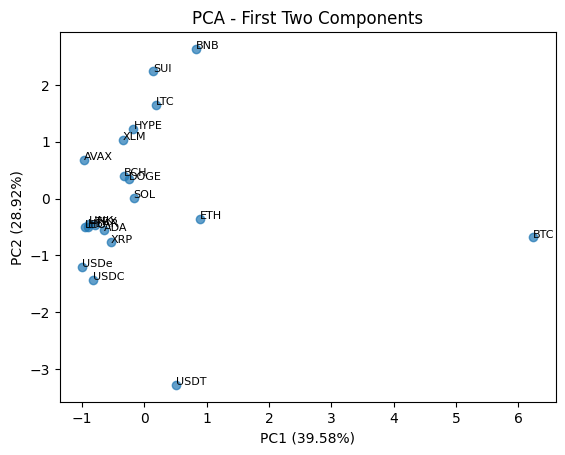

In [79]:
plt.subplot(1, 1, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
for i, symbol in enumerate(pca_df['Symbol']):
    plt.annotate(symbol, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=8)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA - First Two Components')

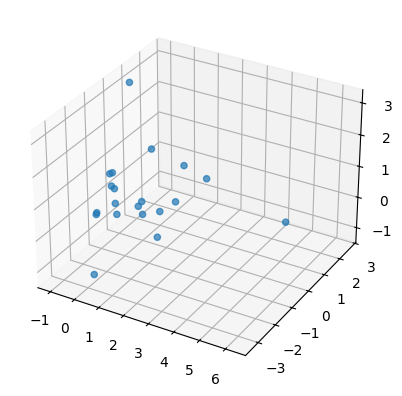

In [80]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], alpha=0.7)
for i, symbol in enumerate(pca_df['Symbol']):
    ax.annotate(symbol, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=8)

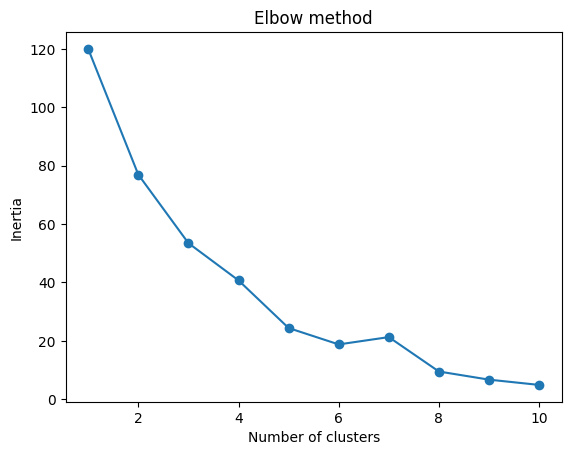

In [81]:
inertias = []
for i in range(1,11):
    kmeans_elbow = KMeans(n_clusters=i)
    kmeans_elbow.fit(df_pca)
    inertias.append(kmeans_elbow.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [82]:
df_pca_2d = pca_df[['PC1', 'PC2']].copy()

kmeans = KMeans(n_clusters=6)
crypto_types_kmeans = kmeans.fit_predict(df_pca_2d)

agglomerative = AgglomerativeClustering(n_clusters=6)
crypto_types_agglomerative = agglomerative.fit_predict(df_pca_2d)

dbscan = DBSCAN()
crypto_types_dbscan = dbscan.fit_predict(df_pca_2d)

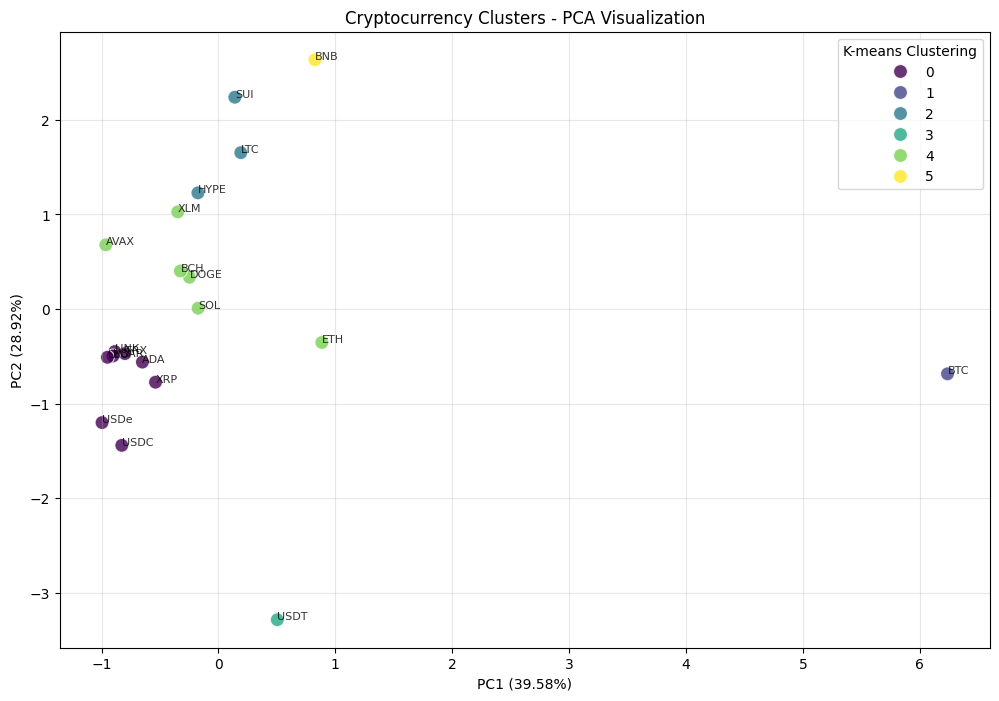

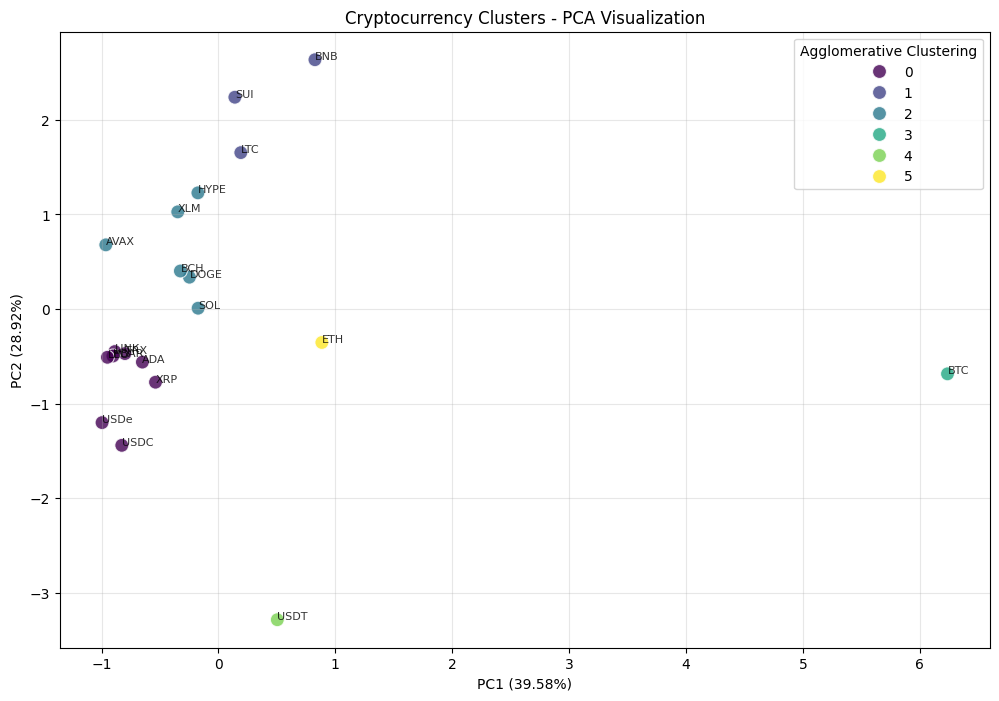

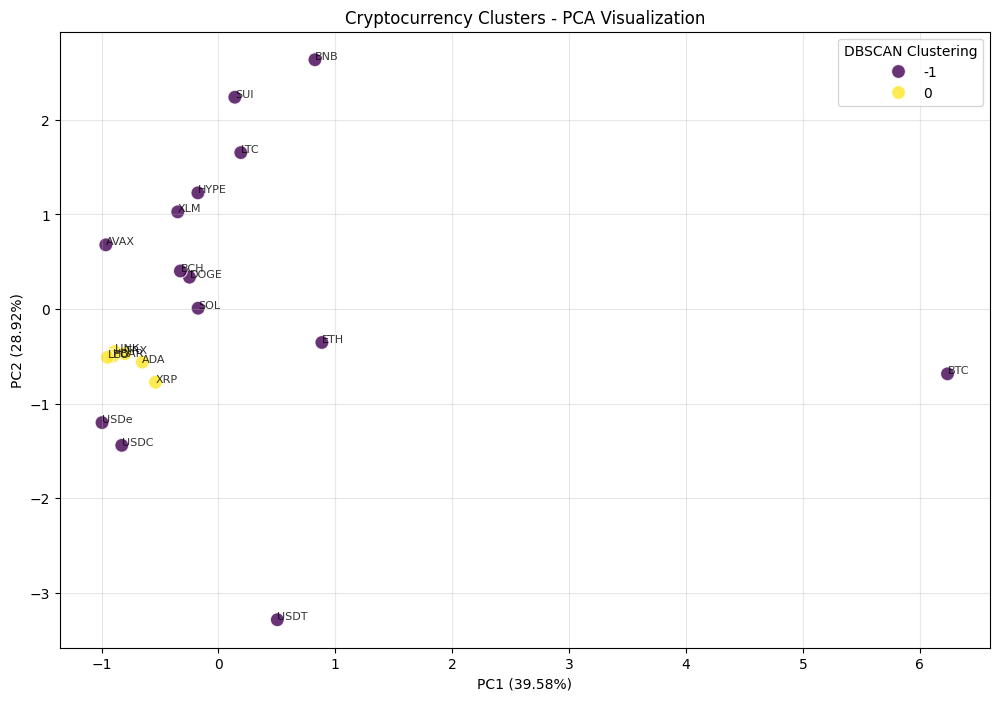

In [83]:
# K-means Clustering
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'Symbol']].copy()
plot_df['Cluster'] = crypto_types_kmeans

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['Symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Cryptocurrency Clusters - PCA Visualization')
plt.legend(title='K-means Clustering')
plt.grid(True, alpha=0.3)
plt.show()

# Agglomerative Clustering
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'Symbol']].copy()
plot_df['Cluster'] = crypto_types_agglomerative

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['Symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Cryptocurrency Clusters - PCA Visualization')
plt.legend(title='Agglomerative Clustering')
plt.grid(True, alpha=0.3)
plt.show()

# DBSCAN Clustering
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'Symbol']].copy()
plot_df['Cluster'] = crypto_types_dbscan

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['Symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Cryptocurrency Clusters - PCA Visualization')
plt.legend(title='DBSCAN Clustering')
plt.grid(True, alpha=0.3)
plt.show()